In [226]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm 

from src2.ValueNetwork import ValueNetwork
from src2.PolicyNetwork import PolicyNetwork
from src2.Trajectories import Trajectories

In [231]:
class PPOAgent:
    def __init__(self,
                 env: gym.Env,
                 state_space_size: int,
                 action_space_size: int,
                 batch_size: int,
                 gamma: float,
                 lmbda: float,
                 epsilon: float,
                 smooting_const: float,
                 shuffle_batches: bool,
                 normalize_advantages: bool = True,
                 dtype: torch.dtype = torch.float32,
                 device: str = 'cpu'):

        self.env = env

        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.gamma = gamma
        self.lmbda = lmbda
        self.epsilon = epsilon
        self.smoothing_constant = smooting_const
        self.normalize_advantages = normalize_advantages
        self.batch_size = batch_size
        self.shuffle_batches = shuffle_batches

        self.dtype = dtype
        self.device = device

        self.value_net = ValueNetwork(state_space_size=self.state_space_size,
                                      dtype=self.dtype,
                                      device=self.device)

        self.policy_net = PolicyNetwork(state_space_size=self.state_space_size,
                                        action_space_size=self.action_space_size,
                                        dtype=self.dtype,
                                        device=self.device)

        self.policy_net_OLD = PolicyNetwork(state_space_size=self.state_space_size,
                                            action_space_size=self.action_space_size,
                                            dtype=self.dtype,
                                            device=self.device)
        # Initialize to same weights as policy net
        self.policy_net_OLD.load_state_dict(self.policy_net.state_dict())

    def get_normalized_advantages(self, advantages: torch.Tensor) -> torch.Tensor:

        normalized_advantages = (advantages - advantages.mean()) / (torch.std(advantages) + self.smoothing_constant)
        return normalized_advantages

    def compute_GAE(self, deltas: torch.Tensor) -> torch.Tensor:

        advantages = torch.zeros_like(deltas)
        advantage = 0.0
        for t in reversed(range(len(deltas))):
            advantage = deltas[t] + self.gamma * self.lmbda * advantage
            advantages[t] = advantage

        if self.normalize_advantages:
            return self.get_normalized_advantages(advantages=advantages)
        return advantages

    def compute_TD_residual(self, rewards: torch.tensor, next_values: torch.tensor, values: torch.tensor) -> torch.tensor:

        return rewards + self.gamma * next_values - values

    def get_policy_loss(self, states: torch.Tensor, actions: torch.Tensor, advantages: torch.Tensor):

        # Compute the probability of the action taken under the old policy
        action_probs_old = self.policy_net_OLD(states)
        pi_old = torch.gather(input=action_probs_old, dim=1, index=actions.unsqueeze(1))
    
        # Compute the probability of the action taken under the current policy
        action_probs_new = self.policy_net(states)
        pi_new = torch.gather(input=action_probs_new, dim=1, index=actions.unsqueeze(1))

        # Compute the ratio r(θ)
        r = (pi_new / pi_old).flatten()

        # Compute the clipped surrogate objective
        surrogate_obj = r * advantages
        
        clipped_obj = torch.clamp(r, 1 - self.epsilon, 1 + self.epsilon) * advantages
        
        # Compute the policy loss
        policy_loss = -torch.min(surrogate_obj, clipped_obj).mean()
        return policy_loss

    def get_value_loss(self, states: torch.Tensor, next_states: torch.Tensor, rewards: torch.Tensor):

        # Compute target value (for last step - set to reward)
        target_values = rewards + self.gamma * self.value_net(next_states).flatten().detach()
        target_values = torch.cat((target_values[:-1], torch.tensor([rewards[-1].item()])))
        
        # Compute estimated value
        estimated_values = self.value_net(states).flatten()
    
        # Compute the value loss
        value_loss = torch.nn.functional.mse_loss(estimated_values, target_values)

        return value_loss

    def train(self, episodes: int, policy_lr: float, value_lr: float, num_policy_epochs: int, num_value_epochs: int):

        # Define the optimizer for the policy network
        policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=policy_lr)

        # Define the optimizer for the value network
        value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=value_lr)

        avg_accumulated_reward = []

        for episode in tqdm(range(episodes)):
            # Retrieving batch of trajectories
            trajectories = Trajectories(batch_size=self.batch_size, env=self.env, policy_network=self.policy_net)
            # States_batch has dims:      (batch size , game length , state space size)
            # next_states_batch has dims: (batch size , game length , state space size)  
            # actions_batch has dims:     (batch size , game length)
            # rewards_batch has dims:     (batch size , game length)
            states_batch, actions_batch, rewards_batch, next_states_batch = trajectories.get_batch()
            # Computing advantages
            advantages_batch = torch.zeros_like(rewards_batch)
            for trajectory in range(self.batch_size):

                states = states_batch[trajectory]
                rewards = rewards_batch[trajectory]
                next_states = next_states_batch[trajectory]
                
                values = self.value_net(states).flatten()
                # The value is 0 at the end of the trajectory (hence the concatenation of 0 at the end)
                next_values = torch.cat((self.value_net(next_states)[:-1].flatten(),torch.tensor([0])))
                deltas = self.compute_TD_residual(rewards=rewards,next_values=next_values,values=values)         
                advantages_batch[trajectory] = self.compute_GAE(deltas=deltas)

            # Store the old policy parameters (before update)
            self.policy_net_OLD.load_state_dict(self.policy_net.state_dict())

            # Policy Network Update:
            for policy_epoch in range(num_policy_epochs):
                for trajectory in range(self.batch_size):
                    states = states_batch[trajectory].detach()
                    actions = actions_batch[trajectory].detach()
                    advantages = advantages_batch[trajectory].detach()
                    
                    # Compute the policy loss
                    policy_loss = self.get_policy_loss(states=states, actions=actions, advantages=advantages)

                    # Update policy parameters using the optimizer
                    policy_optimizer.zero_grad()
                    policy_loss.backward()
                    policy_optimizer.step()
                    
                # Shuffle batch
                if self.shuffle_batches:
                    rng_indices = torch.randperm(n=self.batch_size)
                    states_batch = states_batch[rng_indices]
                    actions_batch = actions_batch[rng_indices]
                    rewards_batch = rewards_batch[rng_indices]
                    next_states_batch = next_states_batch[rng_indices]
                    advantages_batch = advantages_batch[rng_indices]
                

            # Value Network Update
            for value_epoch in range(num_value_epochs):
                for batch in range(self.batch_size):
                    states = states_batch[batch]
                    rewards = rewards_batch[batch]
                    next_states = next_states_batch[batch]

                    # Compute the value loss
                    value_loss = self.get_value_loss(states=states, next_states=next_states, rewards=rewards)

                    # Update value network parameters using the optimizer
                    value_optimizer.zero_grad()
                    value_loss.backward()
                    value_optimizer.step()
                    
                # Shuffle batch
                if self.shuffle_batches:
                    rng_indices = torch.randperm(n=self.batch_size)
                    states_batch = states_batch[rng_indices]
                    actions_batch = actions_batch[rng_indices]
                    rewards_batch = rewards_batch[rng_indices]
                    next_states_batch = next_states_batch[rng_indices]
                    advantages_batch = advantages_batch[rng_indices]

            avg_accumulated_reward.append(float(torch.mean(torch.sum(rewards_batch, dim=1)).detach().numpy()))
        return avg_accumulated_reward




In [232]:
env = gym.make('CartPole-v1')

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

gamma = 0.99
lmbda = 0.925
epsilon = 0.2  
policy_lr = 0.002
value_lr = 0.002
num_policy_epochs = 4
num_value_epochs = 4
smoothing_const = 1e-8
normalize_advantages = True
batch_size = 5
shuffle_batches = False

Agent = PPOAgent(env=env,
                 state_space_size=input_dim,
                 action_space_size=output_dim,
                 gamma=gamma,
                 lmbda=lmbda,
                 epsilon=epsilon,
                 smooting_const=smoothing_const,
                 normalize_advantages=normalize_advantages,
                 batch_size=batch_size,
                 shuffle_batches = shuffle_batches)

In [233]:
num_episodes = 200
accumulated_reward = Agent.train(episodes=num_episodes,
                                 policy_lr=policy_lr,
                                 value_lr=value_lr,
                                 num_policy_epochs=num_policy_epochs,
                                 num_value_epochs=num_value_epochs)

100%|██████████| 200/200 [00:16<00:00, 12.42it/s]


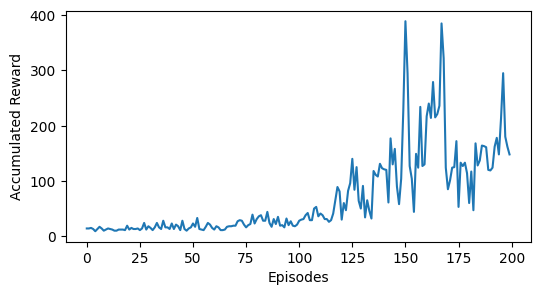

In [234]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.plot([e for e in range(len(accumulated_reward))], accumulated_reward)
ax.set_xlabel('Episodes')
ax.set_ylabel('Accumulated Reward')
plt.show()